In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

def return_scaled_dataframe(dataframe, scaler = StandardScaler()):
    
    to_scale_features = dataframe.select_dtypes([np.number]).columns
    scaled_features = dataframe[to_scale_features].copy()
    scaled_columns = scaled_features.columns
    scaled_features[scaled_columns] = scaler.fit_transform(scaled_features)

    return scaled_features


def clustering_metrics(data):
    
    Sum_of_squared_distances = []
    Silhouette_value = []
    Calinski_Harabasz = []
    Davies_Bouldin = []

    K = range(2, 20 + 1)

    for k in K:

        km = KMeans(n_clusters = k, n_init = 20, max_iter = 500, random_state = 20202020)
        km = km.fit(data)
        labels = km.labels_

        Sum_of_squared_distances.append(km.inertia_)
        Silhouette_value.append(silhouette_score(data, labels, metric = 'euclidean'))
        Calinski_Harabasz.append(calinski_harabasz_score(data, labels))
        Davies_Bouldin.append(davies_bouldin_score(data, labels))

    fig, ax = plt.subplots(ncols = 2, nrows = 2, figsize = (12, 7))

    sns.pointplot(x = list(K), y = Sum_of_squared_distances, markers = 'x', s = 10, ax = ax[0, 0])
    sns.pointplot(x = list(K), y = Silhouette_value, markers = 'x', s = 10, ax = ax[1, 0])
    sns.pointplot(x = list(K), y = Calinski_Harabasz, markers = 'x', s = 10, ax = ax[0, 1])
    sns.pointplot(x = list(K), y = Davies_Bouldin, markers = 'x', s = 10, ax = ax[1, 1])

    ax[0, 0].title.set_text('Sum of squared distances ("elbow")')
    ax[1, 0].title.set_text('Silhouette value')
    ax[0, 1].title.set_text('Calinski-Harabasz')
    ax[1, 1].title.set_text('Davies-Bouldin')

    plt.show()
    
def plot_clusters(data, x, y):
    
    fig = px.scatter(data, x = x, y = y, color = 'clusters', hover_data = ['Team', 'season'],
                     title = 'Clusters plotted via reduced dimensionality', 
                     labels = {'season' : 'Season'},
                     width = 750, height = 550)
    fig.update_layout(showlegend=True)
    fig.show()
    
def show_diff_between_clusters(data):
    
    fig = px.box(data_frame = data, y = 'value', x = 'clusters', color = 'clusters',
                 facet_row_spacing = 0.05, facet_col_spacing = 0.05,
                  title = 'Distribution differences across clusters', facet_col = 'stat', facet_col_wrap = 3,
                  width = 950, height = 1950)

    fig.update_xaxes(visible = True, showticklabels = True, title = None, matches = None, type = 'category', categoryorder='category ascending')
    fig.update_yaxes(visible = True, showticklabels = True, title = None, matches = None)
    fig.for_each_annotation(lambda a: a.update(text = a.text.split('=')[-1]))
    fig.update_traces(marker = {'size' : 4}, line = {'width' : 1})
    fig.update_layout(showlegend=False)
    fig.show()

### Data

In [7]:
data = pd.read_csv('../data/scraped_for_modeling_labeled.csv')
data.drop(['games_played'], 1, inplace = True)
data.fillna(0, inplace = True) # divisions with 0

# from borutapy
keep_cols = ['offense_points_per_game', 'defense_points_per_game', 
             'offense_downs_Fourth Downs_PCT', 'offense_passing_AVG', 'offense_passing_YDS/G', 'offense_passing_RTG', 
             'offense_receiving_AVG', 'defense_passing_AVG', 'defense_passing_RTG', 'defense_receiving_AVG', 
             'punting_punts_per_game', 'defense_passing_SYL_per_game', 'offense_downs_Third Downs_ATT_per_game', 
             'defense_downs_Third Downs_ATT_per_game', 'defense_downs_Fourth Downs_ATT_per_game', 
             'defense_downs_First Downs_penalty_ratio', 'offense_passing_TD_per_game', 
             'offense_passing_INT_per_game', 'defense_passing_INT_per_game', 'offense_pass_TD_to_INT', 
             'defense_pass_TD_to_INT']
data = data[['Team', 'season', 'winner', 'played'] + keep_cols].copy()

without_targets = data.drop(['winner', 'played', 'Team', 'season'], 1).copy()
with_targets = data.drop(['winner', 'Team', 'season'], 1).copy()

### Scaling

In [8]:
without_targets_scaled = return_scaled_dataframe(without_targets)
with_targets_scaled = return_scaled_dataframe(with_targets)

### Clustering metrics

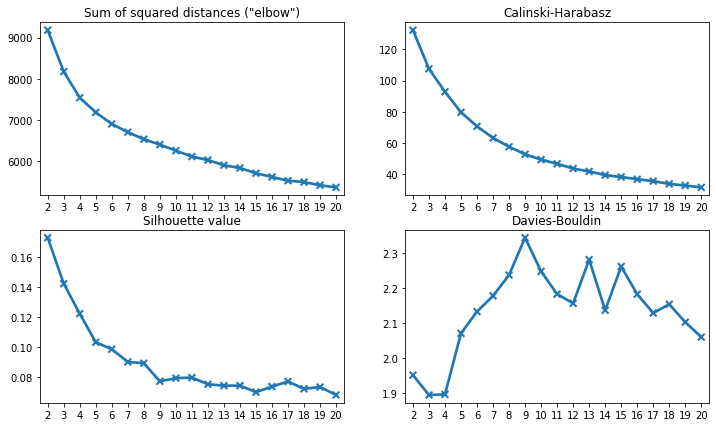

In [9]:
clustering_metrics(without_targets_scaled)

4-5 clusters are probably enough

### Running PCA and plotting clusters

In [10]:
pca = PCA(random_state = 20202020)
pca.fit(without_targets_scaled)

comp = pd.DataFrame(pca.components_, columns = without_targets_scaled.columns)
exp_var = pd.DataFrame(pca.explained_variance_ratio_ * 100, columns = ['Explained variance % '])

pca_results = pd.concat([exp_var, comp], 1)
pca_results.head()

,Explained variance %,offense_points_per_game,defense_points_per_game,offense_downs_Fourth Downs_PCT,offense_passing_AVG,offense_passing_YDS/G,offense_passing_RTG,offense_receiving_AVG,defense_passing_AVG,defense_passing_RTG,...,defense_passing_SYL_per_game,offense_downs_Third Downs_ATT_per_game,defense_downs_Third Downs_ATT_per_game,defense_downs_Fourth Downs_ATT_per_game,defense_downs_First Downs_penalty_ratio,offense_passing_TD_per_game,offense_passing_INT_per_game,defense_passing_INT_per_game,offense_pass_TD_to_INT,defense_pass_TD_to_INT
0,30.383494,0.355933,-0.076518,0.123308,0.352599,0.286883,0.376361,0.212979,-0.012058,-0.008785,...,0.112726,-0.205384,-0.154476,0.190299,0.024801,0.333046,-0.217879,0.060282,0.302169,-0.020469
1,20.071262,-0.045851,0.407251,0.028545,0.037588,0.141725,0.017414,-0.015770,0.419783,0.451852,...,-0.163121,-0.113467,-0.219081,-0.152315,-0.053506,0.052395,0.091581,-0.326931,-0.022440,0.352762
2,6.648343,-0.040890,-0.130338,0.126492,-0.143072,-0.046822,0.103825,-0.300399,-0.109829,0.138555,...,0.301912,0.212758,0.046398,0.008467,0.477355,-0.005606,-0.337160,-0.380194,0.220068,0.313804
3,6.213483,0.040413,0.048891,-0.305589,0.189761,0.225663,-0.093257,0.391989,-0.202272,0.021945,...,0.280804,-0.051899,0.285163,-0.038908,0.263169,0.079314,0.421345,-0.193939,-0.263060,0.225126
4,6.179008,0.120865,0.050471,0.015840,0.015457,0.180196,0.007401,0.140089,0.203004,-0.132799,...,0.166850,0.404578,0.026763,-0.268956,0.335861,0.139727,0.016018,0.225218,0.056801,-0.159510


In [21]:
CLUST_NUMBER = 3

PCAs = pd.DataFrame(pca.transform(without_targets_scaled))[[0, 1]]
PCAs.columns = ['PCA_1', 'PCA_2']

km = KMeans(n_clusters = CLUST_NUMBER, n_init = 20, max_iter = 500, random_state = 20202020).fit(without_targets_scaled)
km = pd.DataFrame(km.predict(without_targets_scaled), columns = ['clusters'])
kmeans_results = pd.concat([data[['Team', 'season']], PCAs, km], 1)
kmeans_results.clusters = kmeans_results.clusters.astype('object')

kmeans_results.head(3)

,Team,season,PCA_1,PCA_2,clusters
0,Kansas City Chiefs,2004,2.681594,4.103946,0
1,Indianapolis Colts,2004,7.692949,0.259475,2
2,Green Bay Packers,2004,1.773290,3.373187,0


In [22]:
kmeans_results.clusters.value_counts()

1    210
2    173
0    161
Name: clusters, dtype: int64

In [23]:
plot_clusters(kmeans_results, 'PCA_1', 'PCA_2')

#### TSNE visualization

In [24]:
# tsne = TSNE(n_components = 2, verbose = 0, random_state = 20202020).fit_transform(without_targets_scaled)
# tsne_plot = pd.DataFrame(tsne)[[0, 1]]
# tsne_plot.columns = ['tSNE_1', 'tSNE_2']
# tsne_results = pd.concat([data[['Team', 'season']], tsne_plot, km], 1)
# tsne_results.clusters = tsne_results.clusters.astype('object')

# plot_clusters(tsne_results, 'tSNE_1', 'tSNE_2')

#### Explore differences across clusters

In [25]:
cluster_exploration = pd.concat([data, km], 1)

cluster_vs_win = cluster_exploration.pivot_table(index = 'clusters', columns = 'winner', values = 'Team', aggfunc = 'count').fillna(0).astype(int)
cluster_vs_play = cluster_exploration.pivot_table(index = 'clusters', columns = 'played', values = 'Team', aggfunc = 'count').fillna(0).astype(int)

cluster_exploration_melt = pd.melt(cluster_exploration, id_vars = ['Team', 'season', 'clusters', 'winner', 'played'], 
                              var_name = 'stat', value_name = 'value')

In [26]:
cluster_vs_win

winner,0,1
clusters,,
0,161,0
1,206,4
2,160,13


In [27]:
cluster_vs_play

played,0,1
clusters,,
0,161,0
1,205,5
2,144,29


In [28]:
show_diff_between_clusters(cluster_exploration_melt)

In [29]:
cluster_exploration[(cluster_exploration['clusters'] == 1) &
                    (cluster_exploration['played'] == 1)]

,Team,season,winner,played,offense_points_per_game,defense_points_per_game,offense_downs_Fourth Downs_PCT,offense_passing_AVG,offense_passing_YDS/G,offense_passing_RTG,...,offense_downs_Third Downs_ATT_per_game,defense_downs_Third Downs_ATT_per_game,defense_downs_Fourth Downs_ATT_per_game,defense_downs_First Downs_penalty_ratio,offense_passing_TD_per_game,offense_passing_INT_per_game,defense_passing_INT_per_game,offense_pass_TD_to_INT,defense_pass_TD_to_INT,clusters
78,Chicago Bears,2006,0,1,26.7,15.9,69.2,6.7,205.1,73.5,...,14.4375,14.9375,1.0000,0.085271,1.5000,1.3750,1.5000,1.090909,0.750000,1
111,New York Giants,2007,1,1,23.3,21.9,35.3,6.2,197.1,73.0,...,13.6875,13.1875,1.0000,0.069444,1.4375,1.2500,0.9375,1.150000,1.600000,1
149,Pittsburgh Steelers,2008,1,1,21.7,13.9,25.0,7.1,206.3,81.9,...,14.0000,14.1250,1.3125,0.075000,1.1875,0.9375,1.2500,1.266667,0.600000,1
271,Baltimore Ravens,2012,1,1,24.9,21.5,42.9,7.1,233.7,86.4,...,13.5625,14.5000,0.7500,0.104294,1.3750,0.6875,0.8125,2.000000,1.153846,1
367,Denver Broncos,2015,1,1,22.2,18.5,50.0,7.0,248.1,76.3,...,14.0000,14.1875,0.8750,0.159170,1.1875,1.4375,0.8750,0.826087,1.357143,1
